# T1 特征、模型重要性分析

## 导入必要的包

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.use14corefonts'] = False
# mpl.rcParams['pdf.usecorefonts'] = True
mpl.rcParams['pdf.compression'] = 9

from IPython.display import display, HTML

import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'nature'])

import statsmodels.formula.api as smf

## 加载数据

In [2]:
result_df = pd.read_excel("out/libfeatureselection/T1/model/Bayes/searched_result.xlsx", "T1", header=[0, 1], index_col=[0, 1])
model_name_list = result_df.loc[result_df.index.levels[0][0], :]["Model_Information"]['Classifier_Name'].to_list()
feature_model_df = result_df['Feature_Selected']
feature_model_df.reset_index(level=1, inplace=True)
feature_df = feature_model_df.iloc[:, 1:].reset_index(drop=True)
model_df = pd.DataFrame(np.eye(feature_model_df['Model_Type'].max()+1)[feature_model_df['Model_Type']], columns=[
    f"model-{i}"
    for i in range(feature_model_df['Model_Type'].max()+1)
]).reset_index(drop=True)
auc_df = result_df['Best_Performance']['rocAUC'].to_frame().reset_index(drop=True)
model_cata_df = feature_model_df['Model_Type'].to_frame().reset_index(drop=True)

## 分析

### 分析特征、模型中谁对AUC更重要

#### 做多元线性回归

In [3]:
formula='rocAUC ~ ' + ' + '.join([
    "Q(\""+i+"\")" 
    for i in feature_df.columns
]) + ' + ' + ' + '.join([
    "Q(\""+i+"\")" 
    for i in model_df.columns
])

df = pd.concat([
    feature_df, model_df, auc_df
], axis=1)
mod = smf.ols(formula=formula, data=df).fit()
state_df = pd.DataFrame([mod.params,mod.pvalues],index=["coef","p"]).T
state_df = state_df[1:]
state_df['p_cut'] = state_df['p'] <= 0.05
state_df.index = [
    i[3:-2]
    for i in state_df.index
]
feature_state_df = state_df[:-15]
model_state_df = state_df[-15:]
model_state_df.index = model_name_list

#### 特征系数

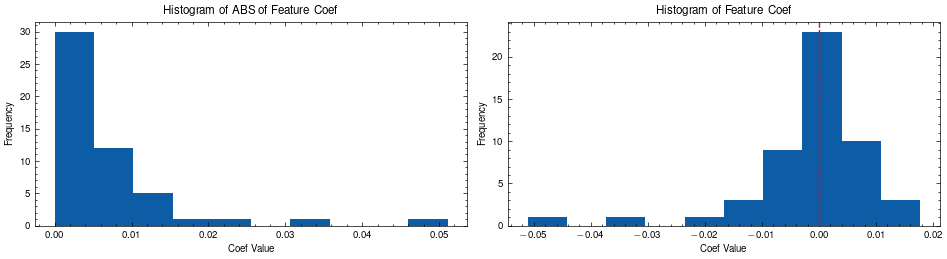

                         coef
PSSM_Composition     0.013255
DP_PSSM              0.014450
S_FPSSM              0.008348
Top_n_gram           0.017756
Similarity_BLOSUM40  0.009149


<Figure size 330x250 with 0 Axes>

In [4]:
plt.figure(figsize=(19.2 / 2, 10.8 / 4))
plt.subplot(1, 2, 1)
plt.hist(
    np.abs(feature_state_df['coef'])
)
plt.title('Histogram of ABS of Feature Coef')
plt.xlabel('Coef Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(
    feature_state_df['coef']
)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Histogram of Feature Coef')
plt.xlabel('Coef Value')
plt.ylabel('Frequency')

plt.tight_layout()
# plt.savefig(f"{path_to_}", transparent=True)
plt.show()
plt.clf()

q3 = np.percentile(feature_state_df['coef'], [(100 - 100 * 5 / feature_state_df['coef'].shape[0]), ])[0]
print(feature_state_df['coef'][feature_state_df['coef'] > q3].to_frame())

#### 模型系数

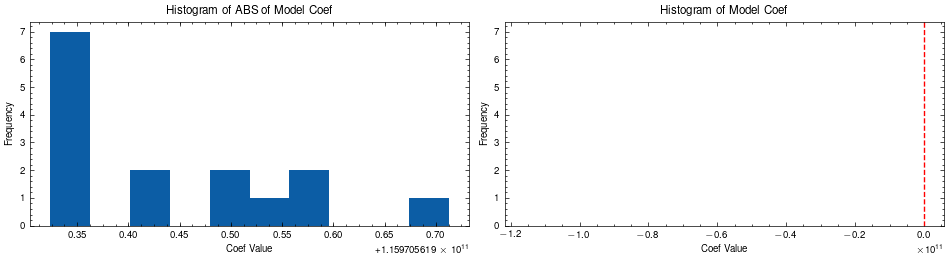

                                    coef
LGBMClassifier             -1.159706e+11
LogisticRegression         -1.159706e+11
ExtraTreesClassifier       -1.159706e+11
GradientBoostingClassifier -1.159706e+11
RandomForestClassifier     -1.159706e+11


<Figure size 330x250 with 0 Axes>

In [5]:
plt.figure(figsize=(19.2 / 2, 10.8 / 4))
plt.subplot(1, 2, 1)
plt.hist(
    np.abs(model_state_df['coef'])
)
plt.title('Histogram of ABS of Model Coef')
plt.xlabel('Coef Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(
    model_state_df['coef']
)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Histogram of Model Coef')
plt.xlabel('Coef Value')
plt.ylabel('Frequency')

plt.tight_layout()
# plt.savefig(f"{path_to_}", transparent=True)
plt.show()
plt.clf()

q3 = np.percentile(model_state_df['coef'], [(100 - 100 * 5 / model_state_df['coef'].shape[0]), ])[0]
print(model_state_df['coef'][model_state_df['coef'] > q3].to_frame())

### 模型特异的重要特征

#### 定义函数做多元线性回归

In [6]:
def ols(model_index: int, feature_df=feature_df):
    feature_df = feature_df[model_index::(feature_model_df['Model_Type'].max()+1)]
    formula='rocAUC ~ ' + ' + '.join([
        "Q(\""+i+"\")" 
        for i in feature_df.columns
    ])

    df = pd.concat([
        feature_df, auc_df
    ], axis=1)
    mod = smf.ols(formula=formula, data=df).fit()
    state_df = pd.DataFrame([mod.params,mod.pvalues],index=["coef","p"]).T
    state_df['p_cut'] = state_df['p'] <= 0.05
    state_df.index = [
        j[3:-2] if i != 0 else j
        for i,j in enumerate(state_df.index)
    ]
    feature_state_df = state_df

    display(HTML(f'<h1>{model_name_list[model_index]}</h1>'))

    plt.figure(figsize=(19.2 / 2, 10.8 / 4))
    plt.subplot(1, 2, 1)
    plt.hist(
        np.abs(feature_state_df['coef'][1:])
    )
    plt.title('Histogram of ABS of Coef')
    plt.xlabel('Coef Value')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(
        feature_state_df['coef'][1:]
    )
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title('Histogram of Coef')
    plt.xlabel('Coef Value')
    plt.ylabel('Frequency')

    plt.tight_layout()
    # plt.savefig(f"{path_to_}", transparent=True)
    plt.show()
    plt.clf()

    q3 = np.percentile(feature_state_df['coef'][1:], [(100 - 100 * 5 / feature_state_df['coef'][1:].shape[0]), ])[0]
    print(feature_state_df['coef'][1:][feature_state_df['coef'][1:] > q3].to_frame().sort_values(by='coef', ascending=False))

    return feature_state_df

#### 运行

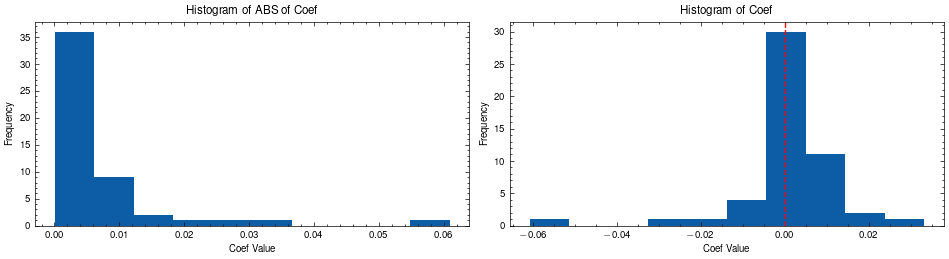

                  coef
DP_PSSM       0.033270
CTDC          0.017238
d_fPSSM       0.014603
MM_Probility  0.011809
AAC           0.011594


<Figure size 330x250 with 0 Axes>

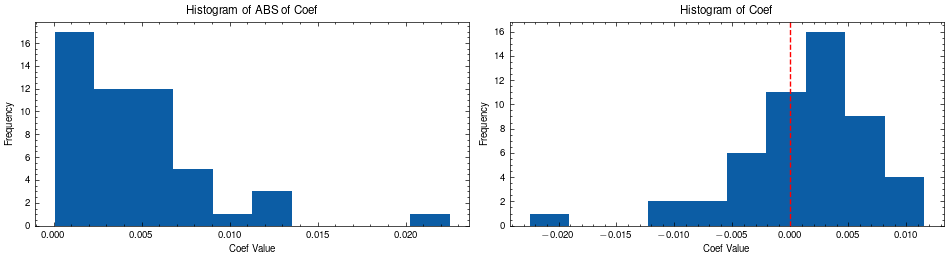

                      coef
DP_PSSM           0.011553
MM_Probility      0.011342
SC_PseAAC         0.008589
PSSM_Composition  0.008345
BertRawEmbedding  0.007357


<Figure size 330x250 with 0 Axes>

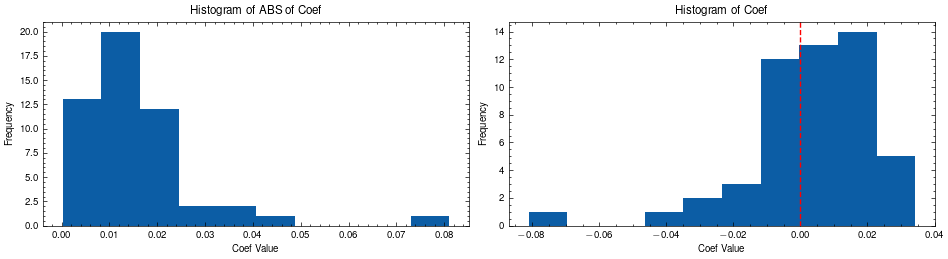

                      coef
PSSM-1000         0.034277
Top_n_gram        0.029293
PSSM_Composition  0.026063
SA-100-AC         0.023656
SS-100-AC         0.023465


<Figure size 330x250 with 0 Axes>

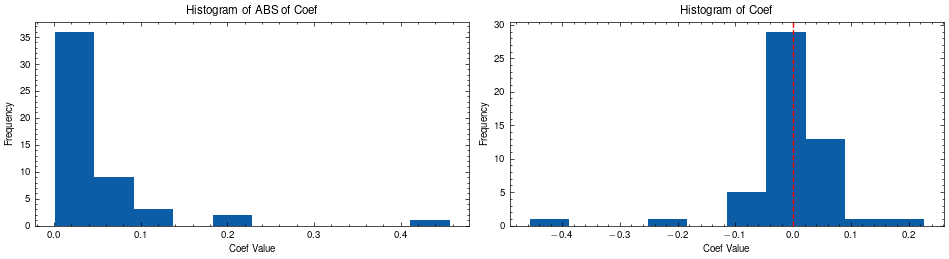

                         coef
PSSM-1000            0.227285
BPBaac               0.097000
Top_n_gram           0.076100
Similarity_BLOSUM40  0.057810
SC_PseAAC            0.052015


<Figure size 330x250 with 0 Axes>

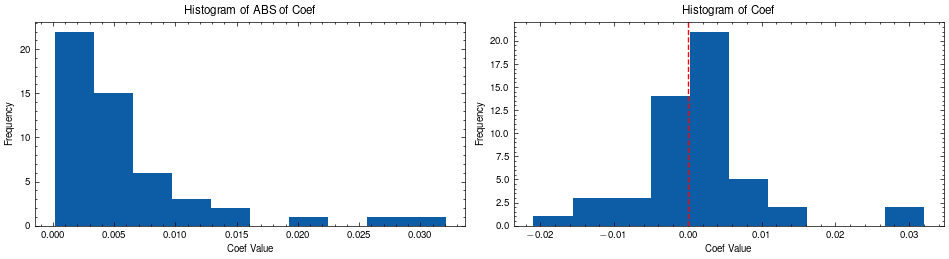

                      coef
BertRawEmbedding  0.032068
CKSAAP            0.026866
PSSM_Composition  0.015327
Top_n_gram        0.014719
TAC               0.009472


<Figure size 330x250 with 0 Axes>

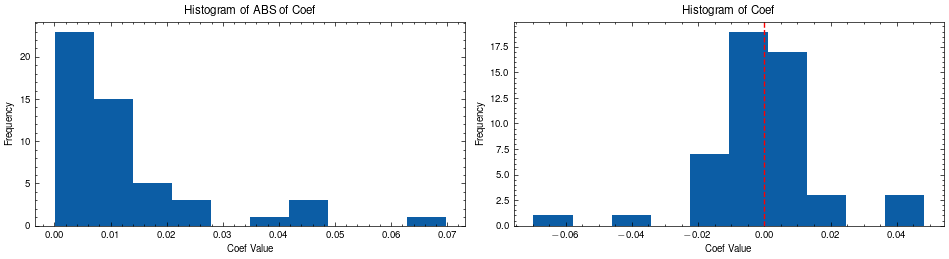

                coef
HH_CKSAAP   0.048346
PSSM-1000   0.045627
Top_n_gram  0.043825
CKSAAP      0.023116
Onehot      0.020306


<Figure size 330x250 with 0 Axes>

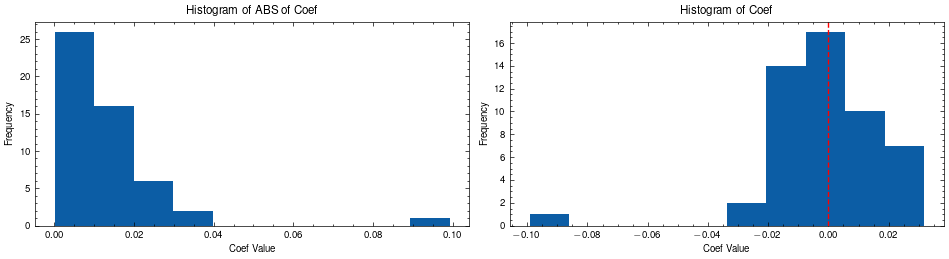

                         coef
DPC_PSSM             0.031820
PC_PseAAC            0.029887
DP_PSSM              0.029423
Similarity_BLOSUM40  0.023590
SS-100-TC            0.022368


<Figure size 330x250 with 0 Axes>

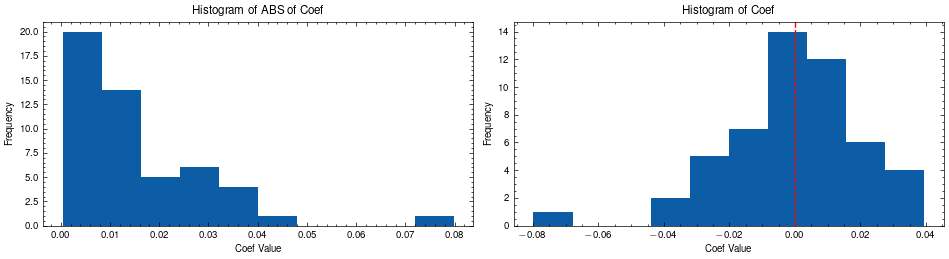

                         coef
DP_PSSM              0.039552
Top_n_gram           0.038583
TPC_PSSM             0.036144
PSSM_Composition     0.030563
Similarity_BLOSUM45  0.027169


<Figure size 330x250 with 0 Axes>

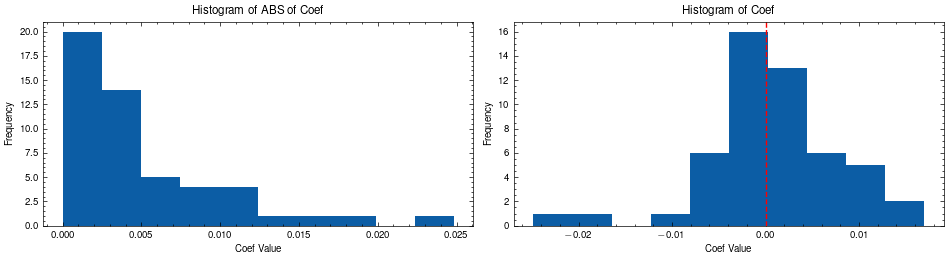

                      coef
DP_PSSM           0.017000
AAC               0.013056
CKSAAP            0.012246
SA-100-DC         0.012196
BertRawEmbedding  0.010889


<Figure size 330x250 with 0 Axes>

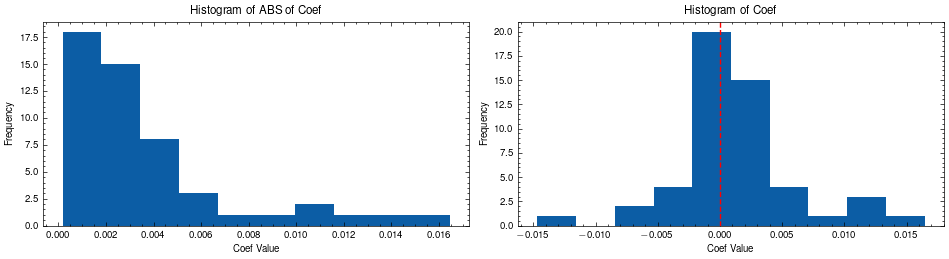

                      coef
BertRawEmbedding  0.016455
CKSAAP            0.012832
PSSM_Composition  0.011127
DP_PSSM           0.010571
CTDC              0.009637


<Figure size 330x250 with 0 Axes>

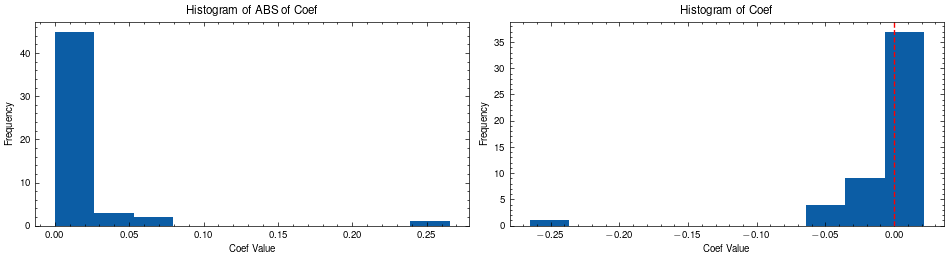

                         coef
PPT_25               0.021953
PSE_PSSM             0.018814
DP_PSSM              0.017451
Rpm_PSSM             0.012158
Similarity_BLOSUM40  0.010304


<Figure size 330x250 with 0 Axes>

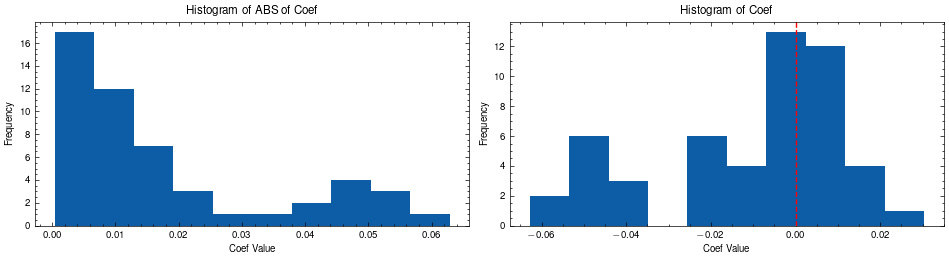

                 coef
SS-100-AC    0.030388
TPC_PSSM     0.017424
DISO-100-DC  0.017049
DP_PSSM      0.015791
PC_PseAAC    0.013517


<Figure size 330x250 with 0 Axes>

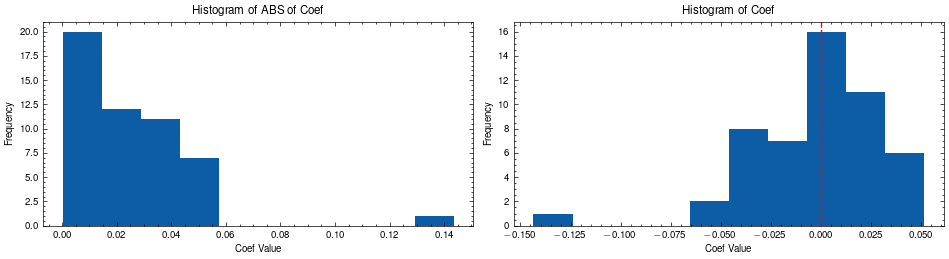

                 coef
CKSAAP       0.051620
DISO-100-AC  0.049609
Top_n_gram   0.045849
TPC_PSSM     0.035268
Rpm_PSSM     0.032700


<Figure size 330x250 with 0 Axes>

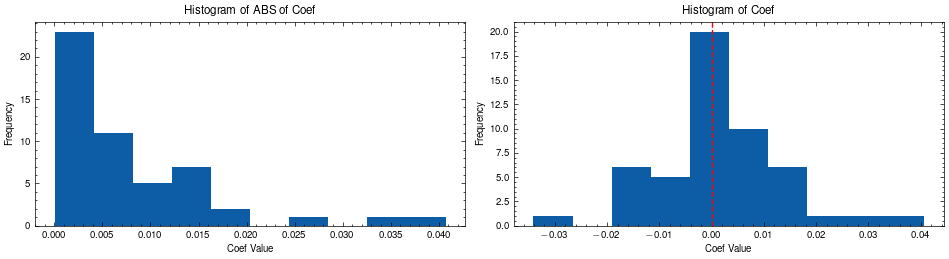

                      coef
CKSAAP            0.040728
Top_n_gram        0.026902
PSSM_Composition  0.019699
PC_PseAAC         0.016981
BertRawEmbedding  0.016237


<Figure size 330x250 with 0 Axes>

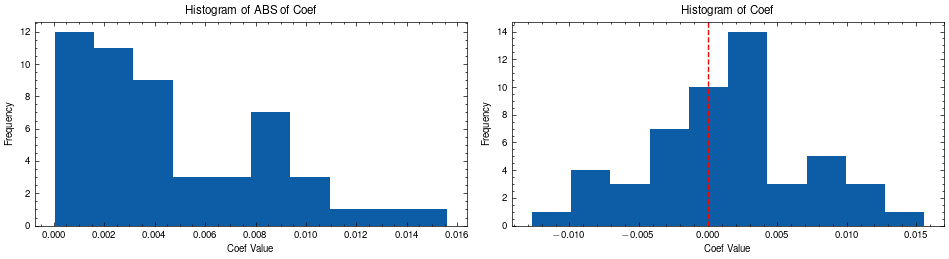

                      coef
PSSM_Composition  0.015607
DP_PSSM           0.012493
CKSAAP            0.010250
BertRawEmbedding  0.010023
CTDC              0.009796


<Figure size 330x250 with 0 Axes>

In [7]:
ols_result = pd.concat([
    ols(i)
    for i, model_name in enumerate(model_name_list)
], axis=1, keys=model_name_list)

#### 模型基准 Intercept

                           Intercept
GradientBoostingClassifier  0.915073
LogisticRegression          0.907867
LGBMClassifier              0.906428
RandomForestClassifier      0.903553
ExtraTreesClassifier         0.89959


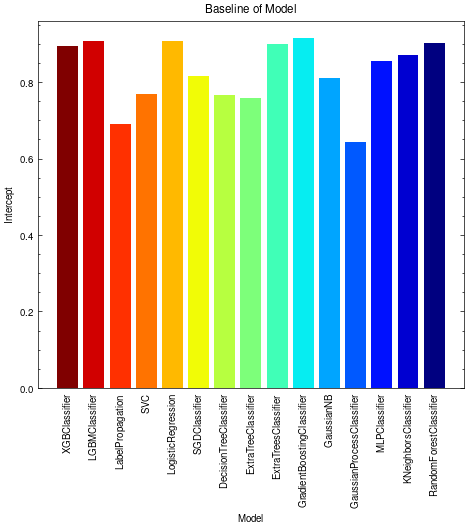

<Figure size 330x250 with 0 Axes>

In [8]:
model_Intercept = ols_result.iloc[0].loc[[ (i, "coef") for i in model_name_list]].reset_index(level=1, inplace=False, drop=True)

q3 = np.percentile(model_Intercept, [(100 - 100 * 5 / model_Intercept.shape[0]), ])[0]
print(model_Intercept[model_Intercept > q3].to_frame().sort_values(by='Intercept', ascending=False))

plt.figure(figsize=(19.2 / 4, 10.8 / 2))
plt.bar(
    model_Intercept.index,
    model_Intercept,
    color=plt.cm.jet(1-np.linspace(0, 1, model_Intercept.shape[0]))
)
plt.xticks(rotation=90)
plt.tick_params(axis='x', which='both', length=0)
plt.title('Baseline of Model')
plt.xlabel('Model')
plt.ylabel('Intercept')

plt.tight_layout()
# plt.savefig(f"{path_to_}", transparent=True)
plt.show()
plt.clf()

In [9]:
display(HTML(ols_result.to_html(float_format="%.4g")))